데이터 전처리 과정 분석

convert_h36m.py 코드를 통해 h36m_sh_conf_cam_source_final.pkl 파일로부터 clip들을 나누어 data/motion3d/MB3D_f243s81/H36M-SH 폴더에 저장함
그 과정에서 전처리 과정을 거쳐 원본 파일과 새로 생성된 파일의 값이 달라짐 -> 이 부분을 이해해야 AI Hub 데이터를 동일한 형식으로 만들어 훈련시킬 수 있음

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result2"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

alphapose_root, motionbert_root, kookmin_root, ap_kookmin_result_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('/home/hrai/codes/AlphaPose',
 '/home/hrai/codes/MotionBERT',
 '/home/hrai/Datasets/HAAI/국민대데이터/data',
 '/home/hrai/codes/AlphaPose/examples/kookmin_result2')

### Generate pkl for each video

In [17]:
root_folder = '/home/hrai/Datasets/HAAI/국민대데이터/'
subject_list = ['S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20']
action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'cat', 'yoga']
phase_list = ['']
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting2'
if not os.path.exists(save_folder): os.makedirs(save_folder)
interpolate_spine = False
if interpolate_spine:
    necessary_joints = [ 0, 1, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 
else:
    necessary_joints = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20] 

lbot = get_lbot(2)
cam_param = readpkl('/home/hrai/Datasets/HAAI/국민대데이터/camera_parameter_estimation/' + 'cam_param2.pkl')

In [18]:
for subject in subject_list:
    for phase in phase_list:
        for action in action_list:
            # load vicon data
            file_path = os.path.join(root_folder, 'data', 'gist data', '{}/{}_{}.csv'.format(subject, subject, action))
            if not os.path.exists(file_path):
                print(file_path, "no csv file")
                continue
            else:
                #print(file_path, 'exists')
                print(subject, action, phase)
            pose3d_list, attribute_list = load_pose3d_kookmin(subject, action, phase, lbot, h36m=False, with_nose=True)  
            
            # check available frames
            available_frames, num_frames = check_available_frame(pose3d_list, necessary_joints, interpolate_spine)
            print( num_frames)
            if available_frames is None: continue
            
            # convert to h36m
            pose3d_list_h36m = kookmin2h36m_with_nose(pose3d_list)

            # generate pkl 
            for camera_id in [1, 2, 3, 4, 5]:
                H, W, R, t, C, calibration_matrix, image = get_cam_param_kookmin(cam_param, subject, camera_id, action)
                camera_param = {
                    'intrinsic': calibration_matrix,
                    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
                }
                generate_kookmin_pkl_for_each_video(pose3d_list=pose3d_list_h36m.copy(), 
                                                    available_frames=available_frames.copy(), 
                                                    subject=subject, 
                                                    camera_id=camera_id, 
                                                    action=action, 
                                                    phase=phase, 
                                                    camera_param=camera_param.copy(), 
                                                    save_folder=save_folder, 
                                                    trans=None, 
                                                    rot=None, 
                                                    centered_root=False, # True: root joint을 (0, 0, 0)으로 이동, False: 원래 위치
                                                    overwrite=True)
        
            print("----------------")
        #break
    #break

S11 squat 
1186


100%|██████████| 1186/1186 [00:02<00:00, 514.86it/s]


----------------
S11 pushup 
1398


 33%|███▎      | 466/1398 [00:01<00:02, 417.85it/s]


KeyboardInterrupt: 

### Generate total pkl file

In [2]:
test1 = ['S12', 'S15', 'S18']
test2 = ['S18', 'S16', 'S19']
test3 = ['S14', 'S13', 'S19']
test4 = ['S11', 'S12', 'S20']
test5 = ['S17', 'S18', 'S11']

test1_name = 's0258'
test2_name = 's0689'
test3_name = 's0349'
test4_name = 's1210'
test5_name = 's0178'

In [13]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

# target 
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting2'
action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'cat', 'yoga']
test_subject = test5
camera_list = [1, 2, 3, 4, 5] # [1, 2, 3, 4, 5]
pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
joint_list = [j for j in range(17)] # [r_knee, r_ankle, l_knee, l_ankle, l_elbow, l_wrist, r_elbow, r_wrist] # [j for j in range(17)]
only_test = False

blacklist = []

for item in os.listdir(pkl_folder):
    subject, cam_num, action = item.split('.')[0].split('_') 
    
    # filtering
    if action not in action_list: continue 
    if int(cam_num) not in camera_list: continue
    if only_test:
        if subject not in test_subject: continue
    if subject in blacklist: continue
    #print(subject, cam_num, action, phase) 
    
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    if subject in test_subject: data_type = 'test' 
    else: data_type = 'train' 
    
    joint_2ds[data_type] += list(np.array(data['joint_2d'])[:, joint_list]) 
    confidences[data_type] += list(np.array(data['confidence'])[:, joint_list]) 
    joint3d_images[data_type] += list(np.array(data['joint3d_image'])[:, joint_list]) 
    joints_25d_images[data_type] += list(np.array(data['joints_2.5d_image'])[:, joint_list]) 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += list(np.array(data['world_3d'])[:, joint_list]) 
    cam_3ds[data_type] += list(np.array(data['cam_3d'])[:, joint_list])
    cam_params[data_type] += data['cam_param'] 
    
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type]))
    
if len(kookmin_total['train']['joint_2d']) == 0:
    kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint3d_image'].shape, kookmin_total['test']['joint3d_image'].shape  

((357180, 17, 3), (156020, 17, 3))

In [14]:
kookmin_total['train']['joint3d_image'].shape[0] + kookmin_total['test']['joint3d_image'].shape[0]

513200

S12_4_cat


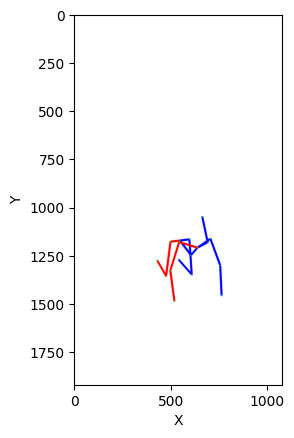

In [67]:
%matplotlib inline
fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig, H=1920, W=1080)
frame_num = 1000
img = get_2d_pose_image(kookmin_total['test']['joint_2d'][frame_num], H=1920, W=1080)
print(kookmin_total['test']['source'][frame_num])
ax.imshow(img)
plt.show()

In [10]:
save_path = os.path.join(motionbert_root, f'data/motion3d/kookmin_total_with_kookmin_setting2_{test5_name}_test.pkl')
savepkl(kookmin_total, save_path)

### Change gt pose2d to ap pose2d (to be continue)

In [5]:
target_pkl = os.path.join(motionbert_root, 'data/motion3d/kookmin_total_with_kookmin_setting2_s0258_test.pkl')
src = readpkl(target_pkl)

In [6]:
src.keys(), src['train'].keys(), src['test'].keys()

(dict_keys(['train', 'test']),
 dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']),
 dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']))

In [7]:
src['test']['frame']

array([   0,    1,    2, ..., 1561, 1562, 1563])

In [28]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'yoga', 'cat']
test_subject = ['S12', 'S15', 'S18'] # ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
camera_list = [1, 2, 3, 4, 5]
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting2'

for item in os.listdir(pkl_folder):
    subject, camera_id, action = item.split('.')[0].split('_') 
    if action not in action_list: continue 
    if subject not in test_subject: continue
    if int(camera_id) not in camera_list: continue
    print(subject, camera_id, action) 
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    #print(data.keys())
    if subject in test_subject: data_type = 'test' 
    else: data_type = 'train' 
    if data_type == 'train': 
        joint_2ds[data_type] += data['joint_2d']
    elif data_type == 'test':
        # load 
        ap_result_path = os.path.join(ap_kookmin_result_root, 'res_{}_{}_{}'.format(subject, action, camera_id))
        video_path = '/home/hrai/Datasets/HAAI/국민대데이터/data/videos/{}/{}_{}_{}.mp4'.format(subject, subject, action, camera_id) 
        joint_2d = get_ap_pose_2d(video_path, ap_result_path)
        joint_2ds[data_type] += list(joint_2d)[2:]
    confidences[data_type] += data['confidence'] 
    joint3d_images[data_type] += data['joint3d_image'] 
    joints_25d_images[data_type] += data['joints_2.5d_image'] 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += data['world_3d'] 
    cam_3ds[data_type] += data['cam_3d'] 
    cam_params[data_type] += data['cam_param'] 
    #break
    
assert len(joint_2ds['test']) == len(joint3d_images['test'])

S12 4 cat
S15 5 squat
S12 5 cat
S15 4 pushup
S18 1 yoga
S12 2 benchpress
S18 2 cat
S12 2 cat
S15 1 yoga
S12 1 pushup
S18 3 cat
S12 4 pushup
S12 2 burpee
S15 2 pushup
S12 1 cat
S15 5 yoga
S12 3 pushup
S18 5 squat
S15 3 cat
S12 4 yoga
S18 1 cat
S15 2 cat
S18 2 yoga
S15 3 burpee
S18 3 squat
S18 1 pushup
S15 1 cat
S15 5 kneeup
S15 4 yoga
S12 3 squat
S18 5 pushup
S18 4 benchpress
S18 4 yoga
S15 5 pushup
S18 2 burpee
S12 2 yoga
S12 3 burpee
S18 5 benchpress
S15 3 squat
S18 5 cat
S12 5 burpee
S15 4 squat
S18 5 burpee
S12 4 squat
S12 5 pushup
S12 1 burpee
S12 2 pushup
S18 2 squat
S18 5 kneeup
S15 2 squat
S12 4 burpee
S15 4 cat
S15 3 pushup
S15 1 squat
S18 1 squat
S12 3 kneeup
S18 4 pushup
S15 1 pushup
S18 5 yoga
S15 3 yoga
S18 2 pushup
S12 5 yoga
S15 4 benchpress
S15 5 cat
S15 3 kneeup
S12 2 kneeup
S12 1 squat
S18 3 pushup
S12 5 benchpress
S12 1 benchpress
S15 5 benchpress
S18 1 burpee
S12 2 squat
S15 2 yoga
S18 4 squat
S18 1 kneeup
S12 3 benchpress
S18 4 kneeup
S18 4 cat
S12 1 yoga
S15 2 benc

In [32]:
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    data_type_ = data_type
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))
    
if len(kookmin_total['train']['joint_2d']) == 0:
    kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint_2d'].shape, kookmin_total['test']['joint_2d'].shape  

((159845, 17, 3), (159845, 17, 3))

In [33]:
save_path = os.path.join(motionbert_root, 'data/motion3d/kookmin_total_with_kookmin_setting2_s0258_test_with_ap.pkl')
savepkl(kookmin_total, save_path)

### Change gt pose2d to mmpose pose2d

In [57]:
test_id = 1
if test_id == 1:
    test = test1
    test_name = test1_name
elif test_id == 2:
    test = test2
    test_name = test2_name
elif test_id == 3:
    test = test3
    test_name = test3_name
elif test_id == 4:
    test = test4
    test_name = test4_name
elif test_id == 5:
    test = test5
    test_name = test5_name
mmpose_model = 'epoch_10'

In [58]:
target_pkl = os.path.join(motionbert_root, f'data/motion3d/kookmin_total_with_kookmin_setting2_{test_name}_test.pkl')
src = readpkl(target_pkl)
target_pkl

'/home/hrai/codes/MotionBERT/data/motion3d/kookmin_total_with_kookmin_setting2_s0258_test.pkl'

In [59]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'yoga', 'cat']
test_subject = test
camera_list = [1, 2, 3, 4, 5]
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/kookmin_pkl_with_kookmin_setting2'

for item in tqdm(os.listdir(pkl_folder)):
    subject, camera_id, action = item.split('.')[0].split('_') 
    if action not in action_list: continue 
    if subject not in test_subject: continue
    if int(camera_id) not in camera_list: continue
    #print(subject, camera_id, action) 
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    #print(data.keys())
    if subject in test_subject: data_type = 'test' 
    else: data_type = 'train' 
    if data_type == 'train': 
        joint_2ds[data_type] += data['joint_2d'] 
    elif data_type == 'test':
        # load 
        video_path = '/home/hrai/Datasets/HAAI/국민대데이터/data/videos/{}/{}_{}_{}.mp4'.format(subject, subject, action, camera_id)
        cap = cv2.VideoCapture(video_path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        with open(f'/home/hrai/codes/mmpose/work_dirs/rtmpose-l_8xb256-420e_kookmin2-256x192_test_{test_name}/kookmin2_{mmpose_model}/results_{subject}_{action}_{camera_id}.json') as f:
            mmpose_result = json.load(f)
        joint_2d = []
        for frame_num in range(num_frames):
            max_score = 0
            max_idx = -1
            for i in range(len(mmpose_result['instance_info'][frame_num]['instances'])):
                #print(np.mean(mmpose_result['instance_info'][frame_num]['instances'][i]['keypoint_scores']))
                if np.mean(mmpose_result['instance_info'][frame_num]['instances'][i]['keypoint_scores']) > max_score:
                    max_score = np.mean(mmpose_result['instance_info'][frame_num]['instances'][i]['keypoint_scores'])
                    max_idx = i
            keypoint = np.array(mmpose_result['instance_info'][frame_num]['instances'][max_idx]['keypoints'])
            joint_2d.append(keypoint)
        joint_2ds[data_type] += joint_2d[2:]
    confidences[data_type] += data['confidence'] 
    joint3d_images[data_type] += data['joint3d_image'] 
    joints_25d_images[data_type] += data['joints_2.5d_image'] 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += data['world_3d'] 
    cam_3ds[data_type] += data['cam_3d'] 
    cam_params[data_type] += data['cam_param'] 
    
assert len(joint_2ds['test']) == len(joint3d_images['test'])

100%|██████████| 350/350 [00:22<00:00, 15.37it/s]


In [60]:
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    data_type_ = data_type
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))
    
if len(kookmin_total['train']['joint_2d']) == 0:
    kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint_2d'].shape, kookmin_total['test']['joint_2d'].shape  

((159845, 17, 2), (159845, 17, 2))

In [61]:
save_path = os.path.join(motionbert_root, f'data/motion3d/kookmin_total_with_kookmin_setting2_{test_name}_test_with_mmpose_test.pkl')
savepkl(kookmin_total, save_path)